In [127]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

from plotting import violinplot_reflected

In [ ]:
# TODO
# format data
# check reference assignment
# summary stats
# activation, PPI, PDI data
# look for examples

In [2]:
df = pd.read_excel('../data/internal/TFiso_LLPS_scores_HEK_20230909_V6.xlsx')
df['gene_symbol'] = df['isoform_acc'].map(lambda x: x.split('|')[0])
df['condensates_observed'] = df['Cond_Score'].map({1: True, 0: False})
df['is_cloned_reference'] = df['Ref_isoform'].map({'Reference': True,
                                                   'Alternative': False})
df['HEK_Condensate'] = df['HEK_Condensate'].str.upper().str.strip()
df['HEK_Condensate'] = df['HEK_Condensate'].map(lambda x: {'BOTH(MOST NC)': 'BOTH'}.get(x, x))
if df['isoform_acc'].duplicated().any():
    raise UserWarning('unexpected duplicates')

In [13]:
df.head()

,Order for analysis,isoform_acc,Ref_isoform,Dest_plate,Well,Length_in_nt,Img_plate,Pos,HEK_Condensate,Cond_Score,Mutation_Class,condensates_observed,is_cloned_reference
0,1,ATF2|1/6|12H04,Reference,GDEhTFISo4LLPS01,A01,1518,Isoform_plate 1,B02,cc,1,Ref,True,True
1,2,ATF2|2/6|09E05,Alternative,GDEhTFISo4LLPS01,B01,1461,Isoform_plate 1,C04,cc,1,Unchanged,True,False
2,3,ATF2|3/6|09C05,Alternative,GDEhTFISo4LLPS01,C01,1341,Isoform_plate 1,D06,NaN,0,LOC,False,False
3,4,ATF2|4/6|09B05,Alternative,GDEhTFISo4LLPS01,D01,735,Isoform_plate 1,E08,cc,1,Unchanged,True,False
4,5,ATF2|5/6|09A05,Alternative,GDEhTFISo4LLPS01,E01,627,Isoform_plate 1,F10,NaN,0,LOC,False,False


In [14]:
df.tail()

,Order for analysis,isoform_acc,Ref_isoform,Dest_plate,Well,Length_in_nt,Img_plate,Pos,HEK_Condensate,Cond_Score,Mutation_Class,condensates_observed,is_cloned_reference
184,188,ZNF473|2/2|01B08,Alternative,GDEhTFISo4LLPS02,D12,231,Isoform_plate 3,D05,NaN,0,LOC,False,False
185,189,ZNF778|1/2|05B07,Reference,GDEhTFISo4LLPS02,E12,2271,Isoform_plate 3,E07,nc,1,Ref,True,True
186,190,ZNF778|2/2|12G05,Alternative,GDEhTFISo4LLPS02,F12,2064,Isoform_plate 3,F09,nc,1,Unchanged,True,False
187,191,ZSCAN9|1/3|11H08,Reference,GDEhTFISo4LLPS02,G12,1185,Isoform_plate 3,G11,nc,1,Ref,True,True
188,192,ZSCAN9|2/3|08H02,Alternative,GDEhTFISo4LLPS02,H12,783,Isoform_plate 4_Hela&U2OS,C03,cc,1,Changed localization,True,False


In [5]:
df.isnull().sum()

Order for analysis     0
isoform_acc            0
Ref_isoform            0
Dest_plate             0
Well                   0
Length_in_nt           0
Img_plate              0
Pos                    0
HEK_Condensate        55
Cond_Score             0
Mutation_Class         0
dtype: int64

In [25]:
df['Mutation_Class'].value_counts()

Unchanged               73
Ref                     60
LOC                     21
GOC                     21
Changed localization    14
Name: Mutation_Class, dtype: int64

In [29]:
print('tested {} isoforms of {} TF genes'.format(df['isoform_acc'].nunique(),
                df['gene_symbol'].nunique())
)
print('{} ({:.0%}) reference isoforms show condensates'.format(
    df.loc[df['is_cloned_reference'], 'condensates_observed'].sum(),
    df.loc[df['is_cloned_reference'], 'condensates_observed'].mean()))
print('{} ({:.0%}) alternative isoforms show condensates'.format(
    df.loc[~df['is_cloned_reference'], 'condensates_observed'].sum(),
    df.loc[~df['is_cloned_reference'], 'condensates_observed'].mean()))
print('{} ({:.0%}) alternative isoforms change condensate formation compared to reference'.format(
    (df.loc[~df['is_cloned_reference'], 'Mutation_Class'] != 'Unchanged').sum(),
    (df.loc[~df['is_cloned_reference'], 'Mutation_Class'] != 'Unchanged').mean()))

print()
print(df.loc[~df['is_cloned_reference'], 'Mutation_Class'].value_counts())
print()



tested 189 isoforms of 60 TF genes
41 (68%) reference isoforms show condensates
93 (72%) alternative isoforms show condensates
56 (43%) alternative isoforms change condensate formation compared to reference

Unchanged               73
LOC                     21
GOC                     21
Changed localization    14
Name: Mutation_Class, dtype: int64



In [42]:
print('all:')
print(df['HEK_Condensate'].value_counts())
print('\nreference:')
print(df.loc[df['is_cloned_reference'], 'HEK_Condensate'].value_counts())
print('\nalternative')
print(df.loc[~df['is_cloned_reference'], 'HEK_Condensate'].value_counts())

all:
CC      75
NC      32
BOTH    27
Name: HEK_Condensate, dtype: int64

reference:
CC      20
NC      11
BOTH    10
Name: HEK_Condensate, dtype: int64

alternative
CC      55
NC      21
BOTH    17
Name: HEK_Condensate, dtype: int64


In [43]:
pairs = pd.read_csv('../output/TF-iso_ref-vs-alt.tsv', sep='\t')
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.000000,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.000000,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,False,743,755,15,16,True,False,False,False,True,False,False,False,0.0,0.000000,False,98.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,True,181,135,3,3,False,True,False,False,False,False,False,False,19.0,46.774194,True,65.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389


In [45]:
df = df.set_index('isoform_acc')

In [46]:
df.head()

,Order for analysis,Ref_isoform,Dest_plate,Well,Length_in_nt,Img_plate,Pos,HEK_Condensate,Cond_Score,Mutation_Class,condensates_observed,is_cloned_reference,gene_symbol
isoform_acc,,,,,,,,,,,,,
ATF2|1/6|12H04,1,Reference,GDEhTFISo4LLPS01,A01,1518,Isoform_plate 1,B02,CC,1,Ref,True,True,ATF2
ATF2|2/6|09E05,2,Alternative,GDEhTFISo4LLPS01,B01,1461,Isoform_plate 1,C04,CC,1,Unchanged,True,False,ATF2
ATF2|3/6|09C05,3,Alternative,GDEhTFISo4LLPS01,C01,1341,Isoform_plate 1,D06,NaN,0,LOC,False,False,ATF2
ATF2|4/6|09B05,4,Alternative,GDEhTFISo4LLPS01,D01,735,Isoform_plate 1,E08,CC,1,Unchanged,True,False,ATF2
ATF2|5/6|09A05,5,Alternative,GDEhTFISo4LLPS01,E01,627,Isoform_plate 1,F10,NaN,0,LOC,False,False,ATF2


In [47]:
for x in ['ref', 'alt']:
    for var in ['condensates_observed', 'HEK_Condensate']:
        pairs[var + '_' + x] = pairs['clone_acc_' + x].map(df[var])

In [51]:
pairs['condensate_cat'] = pairs['clone_acc_alt'].map(df['Mutation_Class'])

In [49]:
pairs = pairs.loc[pairs['condensates_observed_ref'].notnull(), :]

In [52]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,condensates_observed_ref,HEK_Condensate_ref,condensates_observed_alt,HEK_Condensate_alt,condensate_cat
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.0,False,98.1,4.0,3.0,4.0,4.0,3.0,3.0,0.75,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414,True,BOTH,True,NC,Unchanged
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.0,False,82.0,0.0,13.0,13.0,0.0,13.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,False,NaN,False,NaN,Unchanged
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.0,False,81.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958,False,NaN,False,NaN,Unchanged
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,True,602,626,16,16,False,True,False,False,False,False,False,False,0.0,0.0,False,90.9,2.0,0.0,2.0,2.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.436213,-0.241994,-0.678207,True,CC,False,NaN,LOC
6,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,True,602,607,16,16,True,False,False,False,False,False,False,False,0.0,0.0,False,98.4,2.0,0.0,2.0,2.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN,NaN,NaN,NaN,False,0.436213,0.248480,-0.187733,True,CC,False,NaN,LOC


In [55]:
pairs['condensate_cat'].value_counts()

Unchanged               73
LOC                     21
GOC                     21
Changed localization    14
Name: condensate_cat, dtype: int64

In [66]:
pairs['condensate_cat_merged'] = pairs['condensate_cat'].map({
    'Unchanged': 'No difference',
    'LOC': 'Difference',
    'GOC': 'Difference',
    'Changed localization': 'Difference',
    })

In [125]:
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

def permutation_test(x, y):
    """
    two-sided
    """
    nx = x.shape[0]
    ny = y.shape[0]
    obs = x.mean() - y.mean()
    merged = np.concatenate([x, y])
    rnd = []
    for _i in range(10000):
        np.random.shuffle(merged)
        rnd.append(merged[:nx].mean() - merged[nx:].mean())
    return (min([sum(r >= obs for r in rnd), sum(r <= obs for r in rnd)]) / len(rnd)) * 2

permutation_test(x, y)

0.0158

In [151]:
pairs.loc[(pairs['n_positive_PPI_ref'] == 0) | (pairs['n_positive_PPI_alt'] == 0),
          'PPI_jaccard'] = np.nan

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.04


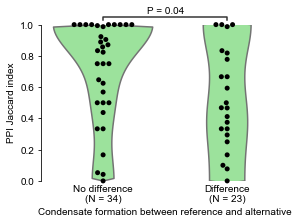

In [152]:
# TODO: do these each have at least one PPI??????
var = 'PPI_jaccard'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
violinplot_reflected(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
                    inner=None,
              #cut=0,
              color='lightgreen',
              order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)

pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PPI Jaccard index')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../figures/PPI-Jaccard-vs-condensate-change_boxplot.pdf',
            bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.28


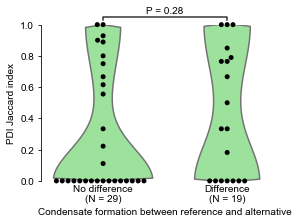

In [145]:
var = 'PDI_jaccard'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
violinplot_reflected(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
                    inner=None,
              #cut=0,
              color='lightgreen',
              order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)

pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PDI Jaccard index')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../figures/PDI-Jaccard-vs-condensate-change_boxplot.pdf',
            bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.04


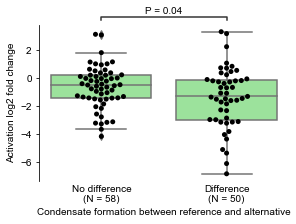

In [153]:
var = 'activation_fold_change_log2'
x = pairs.loc[(pairs['condensate_cat'] == 'Unchanged')
              & pairs[var].notnull(), 
              var].values
y = pairs.loc[(pairs['condensate_cat'] != 'Unchanged')
              & pairs[var].notnull(), 
              var].values

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              order=['No difference', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
sns.boxplot(data=pairs,
                     x='condensate_cat_merged',
                     y=var,
              #cut=0,
              color='lightgreen',
              order=['No difference', 'Difference'],
              ax=ax,
              )

pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])

ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../figures/activation-vs-condensate-change_boxplot.pdf',
            bbox_inches='tight')